
# getting used to dynamic programming
get the U policy matrix of forces for a point mass system with drag

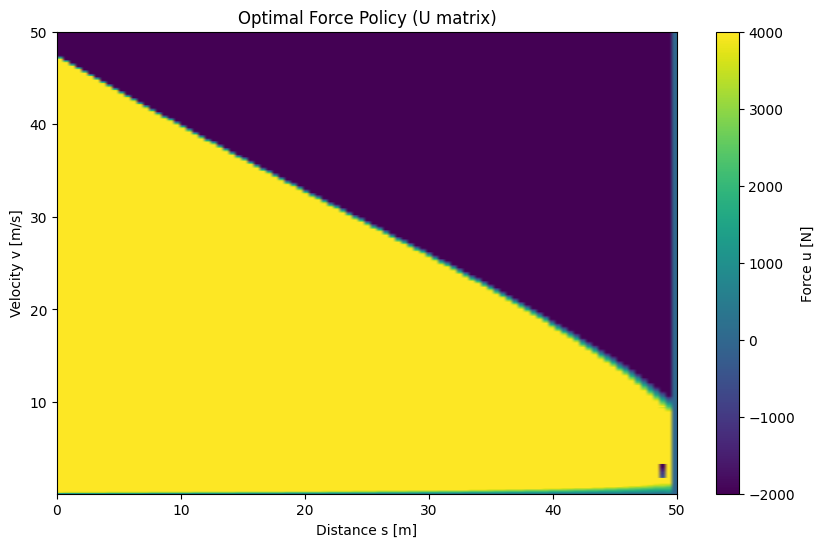

In [93]:

import numpy as np
import matplotlib.pyplot as plt

v_min = 0.1      
v_max = 50
L = 50

u_min = -2000
u_max = 4000
m = 180     #kg
CdA = 2     #m^2

ds = 0.5       # spatial step [m]
v_T = 10.06     # target terminal velocity

# Discretization
Ns = int(L/ds) + 1       # distance grid divisions
Nv = 400     # veocity grid divisions
Nu = 30      # force gird divisions

s_grid = np.linspace(0.0, L, Ns)
v_grid = np.linspace(v_min, v_max, Nv)
u_grid = np.linspace(u_min, u_max, Nu)
ds = s_grid[1]-s_grid[0]

# Cost matrix
J = np.full((Nv, Ns), np.inf)

#set the initial cost as sqaured distance form desired terminal velocity
for j, cost in enumerate(J[: , -1]):
    value = (v_grid[j] - v_T) ** 2
    J[j , -1] = value



#optimal force policy
U = np.zeros((Nv, Ns))

for k in range(Ns - 2, -1, -1):
    for j, v in enumerate(v_grid):
        dt = ds / v
        best_cost = np.inf
        best_u = 0

        for u in u_grid:
            v_next = v + (dt/m) * (u - CdA * v**2)

            #interpolation
            if v_next <= v_grid[0]:
                continue
            elif v_next >= v_grid[-1]:
                continue
            else:
                hi = np.searchsorted(v_grid, v_next) # finds index where velocity would be inserted
                lo = hi - 1
                w = (v_next - v_grid[lo]) / (v_grid[hi] - v_grid[lo])

                if J[lo, k + 1] == np.inf:
                    print("infinity in lo")

                if J[hi, k + 1] == np.inf:
                    print("infinity in hi")

                Jn = (1-w) * J[lo, k + 1] + w * J[hi, k + 1]

            total_cost = dt + Jn
            if total_cost < best_cost:
                best_cost = total_cost
                best_u = u

        J[j, k] = best_cost
        U[j, k] = best_u

plt.figure(figsize=(10, 6))
plt.imshow(U, origin='lower', aspect='auto',
           extent=[s_grid[0], s_grid[-1], v_grid[0], v_grid[-1]],
           cmap='viridis')
plt.colorbar(label='Force u [N]')
plt.xlabel('Distance s [m]')
plt.ylabel('Velocity v [m/s]')
plt.title('Optimal Force Policy (U matrix)')
plt.show()


# nevypínat, chroustá to číslíčka


chatgpt generated slop to plot the trajectory stemming from optimal force policy:


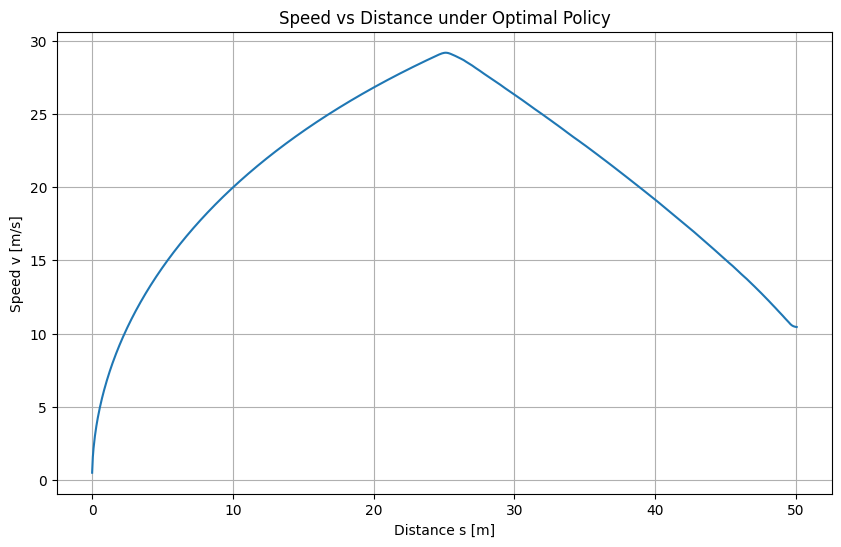

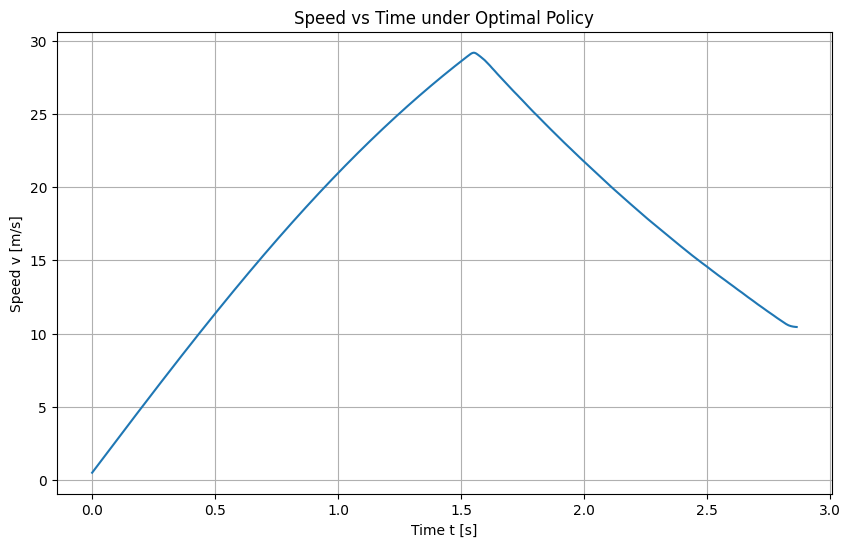

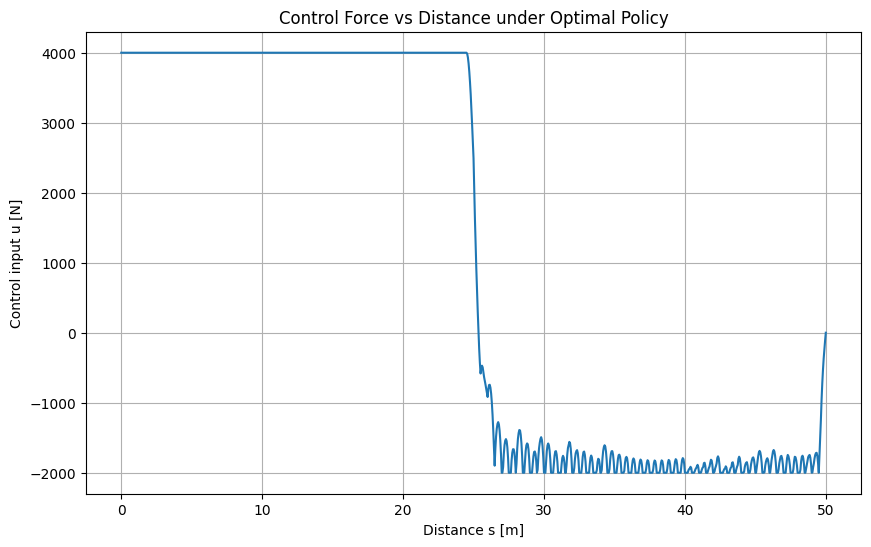

In [94]:
U = U.T
J = J.T

def interp2_policy(U, s, v, s_grid, v_grid):
    s = np.clip(s, s_grid[0], s_grid[-1])
    v = np.clip(v, v_grid[0], v_grid[-1])
    i = np.searchsorted(s_grid, s) - 1
    j = np.searchsorted(v_grid, v) - 1
    i = np.clip(i, 0, len(s_grid)-2)
    j = np.clip(j, 0, len(v_grid)-2)
    s0, s1 = s_grid[i], s_grid[i+1]
    v0, v1 = v_grid[j], v_grid[j+1]
    ts = 0.0 if s1 == s0 else (s - s0)/(s1 - s0)
    tv = 0.0 if v1 == v0 else (v - v0)/(v1 - v0)
    Q11, Q21 = U[i, j],   U[i+1, j]
    Q12, Q22 = U[i, j+1], U[i+1, j+1]
    return (1-ts)*(1-tv)*Q11 + ts*(1-tv)*Q21 + (1-ts)*tv*Q12 + ts*tv*Q22

s0, v0 = 0.0, 0.5
ds_sim = 0.05
s_hist, v_hist, t_hist, u_hist = [s0], [v0], [0.0], []
s, v, t = s0, v0, 0.0

for _ in range(int(np.ceil((L - s0)/ds_sim)) + 5000):
    if s >= L:
        break
    u = float(interp2_policy(U, s, v, s_grid, v_grid))
    v_sq_next = v**2 + (2.0/m)*(u - CdA*v**2)*ds_sim
    if v_sq_next <= 0:
        v_next, s_next = 0.0, s
        s_hist.append(s_next); v_hist.append(v_next); t_hist.append(t); u_hist.append(u)
        break
    v_next = np.sqrt(v_sq_next)
    v_avg = max(1e-6, 0.5*(v + v_next))
    t += ds_sim / v_avg
    s += ds_sim
    s_hist.append(s); v_hist.append(v_next); t_hist.append(t); u_hist.append(u)
    v = v_next

plt.figure(figsize=(10,6))
plt.plot(s_hist, v_hist)
plt.xlabel("Distance s [m]"); plt.ylabel("Speed v [m/s]")
plt.title("Speed vs Distance under Optimal Policy"); plt.grid(True); plt.show()

plt.figure(figsize=(10,6))
plt.plot(t_hist, v_hist)
plt.xlabel("Time t [s]"); plt.ylabel("Speed v [m/s]")
plt.title("Speed vs Time under Optimal Policy"); plt.grid(True); plt.show()

plt.figure(figsize=(10,6))
plt.plot(s_hist[:-1], u_hist)  
plt.xlabel("Distance s [m]")
plt.ylabel("Control input u [N]")
plt.title("Control Force vs Distance under Optimal Policy")
plt.grid(True)
plt.show()